In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
import seaborn as sns
sns.set_theme(style = 'whitegrid')
from PIL import Image
import os

In [9]:
class Solver:

    def __init__(self, h):
        self.gamma = 5. / 3
        self.L = 10
        self.T = 0.02
        self.maxCFL = 0.005

        self.v_l = 0
        self.rho_l = 13 # кг / м^3
        self.P_l = 10 * 101325 # Па
        self.v_r = 0
        self.rho_r = 1.3 
        self.P_r = 101325

        self.h = h

        self.tau = self.maxCFL * self.h
        self.t = 0
        
        self.NX = int(2 * self.L / self.h + 1)
        self.x_i = np.linspace(-self.L, self.L, self.NX)

        ## Начальные условия
        self.w_i = np.zeros((3, self.NX))

        for i in range(self.NX // 2):
            self.w_i[0, i] = self.rho_l
            self.w_i[2, i] = self.P_l / (self.gamma - 1)

        for i in range((self.NX // 2), self.NX):
            self.w_i[0, i] = self.rho_r
            self.w_i[2, i] = self.P_r / (self.gamma - 1)

        self.v_i = np.zeros((3, self.NX))
        self.P_i = np.zeros(self.NX)
        self.v_i[0, :] = self.w_i[0, :] 
        self.v_i[1, :] = self.w_i[1, :]
        self.v_i[2, :] = self.w_i[2, :] / self.w_i[0, :]
        self.P_i = (self.gamma - 1) * self.w_i[2, :] 

        ## Графики

        ## Плотность
        plt.figure(figsize=(10, 6))
        plt.scatter(self.x_i, self.v_i[0, :], color = 'grey')
        plt.ylim([self.v_i[0, :].min(), self.v_i[0, :].max()])
        plt.title(f'rho(t)\nt = 0, h = {self.h}',
                fontsize=14)
        if not os.path.exists(f'./img/rho'):
                    os.mkdir(f'./img/rho')
        plt.savefig(f'./img/rho/img_0.png', 
                transparent = False,  
                facecolor = 'white'
                )
        plt.close()
        ## Скорость
        plt.figure(figsize=(10, 6))
        plt.scatter(self.x_i, self.v_i[1, :], color = 'grey')
        plt.ylim([self.v_i[1, :].min(), self.v_i[1, :].max()])
        plt.title(f'u(t)\nt = 0, h = {self.h}',
                fontsize=14)
        if not os.path.exists(f'./img/u'):
                    os.mkdir(f'./img/u')
        plt.savefig(f'./img/u/img_0.png', 
                transparent = False,  
                facecolor = 'white'
                )
        plt.close()
        ## Энергия
        plt.figure(figsize=(10, 6))
        plt.scatter(self.x_i, self.v_i[2, :], color = 'grey')
        plt.ylim([self.v_i[2, :].min(), self.v_i[2, :].max()])
        plt.title(f'e(t)\nt = 0, h = {self.h}',
                fontsize=14)
        if not os.path.exists(f'./img/e'):
                    os.mkdir(f'./img/e')
        plt.savefig(f'./img/e/img_0.png', 
                transparent = False,  
                facecolor = 'white'
                )
        plt.close()
        ## Давление
        plt.figure(figsize=(10, 6))
        plt.scatter(self.x_i, self.P_i, color = 'grey')
        plt.ylim([self.P_i.max(), self.P_i.min()])
        plt.title(f'P(t)\nt = 0, h = {self.h}',
                fontsize=14)
        if not os.path.exists(f'./img/P'):
                    os.mkdir(f'./img/P')
        plt.savefig(f'./img/P/img_0.png', 
                transparent = False,  
                facecolor = 'white'
                )
        plt.close()

        ## Массив следующего слоя по времени
        self.w_i_next = np.zeros((3, self.NX))
        self.v_i_next = np.zeros((3, self.NX))


    def solveAndCreateGif(self):
        self.t_counter = 0
        image_path_list_rho = ['./img/rho/img_0.png']
        image_path_list_u = ['./img/u/img_0.png']
        image_path_list_e = ['./img/e/img_0.png']
        image_path_list_P = ['./img/P/img_0.png']
        while self.t <= self.T:
            self.t_counter += 1
            self.t += self.tau
            for i in range(1, self.NX - 1):
                c = np.sqrt(self.gamma * (self.gamma - 1) * self.v_i[2, i])
                omega_T = np.zeros((3,3))
                u = self.v[1, i]
                epsilon = self.v[2, i]
                omega_T[0, 0] = -u * c 
                omega_T[0, 1] = c 
                omega_T[0, 2] = u - 1
                omega_T[1, 0] = -c * c
                omega_T[1, 2] = self.gamma - 1
                omega_T[2, 0] = u * c
                omega_T[2, 1] = -c
                omega_T[2, 2] = self.gamma - 1

                omega_T_inv = np.linalg.inv(omega_T)

                lmbda = np.zeros((3, 3))
                lmbda[0, 0] = u + c
                lmbda[1, 1] = u
                lmbda[2, 2] = u - c

                lmbda_abs = np.abs(lmbda)
                A = np.zeros((3, 3))
                A[0, 1] = 1
                A[1, 0] = -u * u
                A[1, 1] = 2 * u
                A[1, 2] = self.gamma - 1
                A[2, 0] = - self.gamma * u * epsilon
                A[2, 1] = self.gamma * epsilon
                A[2, 2] = u

                component1 = np.matmul(A, (self.w_i[:, i + 1] - self.w_i[:, i - 1] / (2 * self.h)))
                component2_1 = np.matmul(np.matmul(omega_T_inv, lmbda_abs), omega_T)
                component2_2 = (self.w[:, i + 1] - 2 * self.w[:, i] + self.w[: i - 1]) / (2 * self.h)
                component2 = np.matmul(component2_1, component2_2) 
                self.w_i_next[:, i] =  self.w_i[:, i] - self.tau * component1 + self.tau * component2
                
            self.v_i_next[0, :] = self.w_i_next[0, :] 
            self.v_i_next[1, :] = self.w_i_next[1, :]
            self.v_i_next[2, :] = self.w_i_next[2, :] / self.w_i_next[0, :]

            ##Учет ГУ
            self.v_i_next[:, 0] = self.v_i_next[:, 1]
            self.v_i_next[:, -1] = self.v_i_next[:, -2]
            self.P_i = (self.gamma - 1) * self.v_i_next[0, :] * self.v_i_next[2, :]

            ##Учет ГУ для w
            self.w_i_next[0, 0] = self.v_i_next[0, 1] 
            self.w_i_next[1, 0] = self.v_i_next[0, 1] * self.v_i_next[1, 1] 
            self.w_i_next[2, 0] = self.v_i_next[0, 1] * self.v_i_next[2, 1] 

            self.w_i_next[0, -1] = self.v_i_next[0, -2] 
            self.w_i_next[1, -1] = self.v_i_next[0, -2] * self.v_i_next[1, -2] 
            self.w_i_next[2, -1] = self.v_i_next[0, -2] * self.v_i_next[2, -2] 

            self.w_i = self.w_i_next.copy()
            self.v_i = self.v_i_next.copy()    
            
            ## Графики

            ## Плотность
            plt.figure(figsize=(10, 6))
            plt.scatter(self.x_i, self.v_i[0, :], color = 'grey')
            plt.ylim([self.v_i[0, :].min(), self.v_i[0, :].max()])
            plt.title(f'rho(t)\nt = {self.t}, h = {self.h}',
                    fontsize=14)
            if not os.path.exists(f'./img/rho'):
                        os.mkdir(f'./img/rho')
            plt.savefig(f'./img/rho/img_{self.t_counter}.png', 
                    transparent = False,  
                    facecolor = 'white'
                    )
            plt.close()
            ## Скорость
            plt.figure(figsize=(10, 6))
            plt.scatter(self.x_i, self.v_i[1, :], color = 'grey')
            plt.ylim([self.v_i[1, :].min(), self.v_i[1, :].max()])
            plt.title(f'u(t)\nt = {self.t}, h = {self.h}',
                    fontsize=14)
            if not os.path.exists(f'./img/u'):
                        os.mkdir(f'./img/u')
            plt.savefig(f'./img/u/img_{self.t_counter}.png', 
                    transparent = False,  
                    facecolor = 'white'
                    )
            plt.close()
            ## Энергия
            plt.figure(figsize=(10, 6))
            plt.scatter(self.x_i, self.v_i[2, :], color = 'grey')
            plt.ylim([self.v_i[2, :].min(), self.v_i[2, :].max()])
            plt.title(f'e(t)\nt = {self.t}, h = {self.h}',
                    fontsize=14)
            if not os.path.exists(f'./img/e'):
                        os.mkdir(f'./img/e')
            plt.savefig(f'./img/e/img_{self.t_counter}.png', 
                    transparent = False,  
                    facecolor = 'white'
                    )
            plt.close()
            ## Давление
            plt.figure(figsize=(10, 6))
            plt.scatter(self.x_i, self.P_i, color = 'grey')
            plt.ylim([self.P_i.max(), self.P_i.min()])
            plt.title(f'P(t)\nt = {self.t}, h = {self.h}',
                    fontsize=14)
            if not os.path.exists(f'./img/P'):
                        os.mkdir(f'./img/P')
            plt.savefig(f'./img/P/img_{self.t_counter}.png', 
                    transparent = False,  
                    facecolor = 'white'
                    )
            plt.close()

            image_path_list_rho.append(f'./img/rho/img_{self.t_counter}.png')
            image_path_list_u.append(f'./img/u/img_{self.t_counter}.png')
            image_path_list_e.append(f'./img/e/img_{self.t_counter}.png')
            image_path_list_P.append(f'./img/P/img_{self.t_counter}.png')


        image_list = [Image.open(file) for file in image_path_list_rho]
        image_list[0].save(
                f'gifs/rho_CFL{self.maxCFL}_h{self.h}.gif',
                save_all=True,
                append_images=image_list[1:], # append rest of the images
                duration=0.08, # in milliseconds
                loop=0)
        image_list = [Image.open(file) for file in image_path_list_u]
        image_list[0].save(
                f'gifs/u_CFL{self.maxCFL}_h{self.h}.gif',
                save_all=True,
                append_images=image_list[1:], # append rest of the images
                duration=0.08, # in milliseconds
                loop=0)
        image_list = [Image.open(file) for file in image_path_list_e]
        image_list[0].save(
                f'gifs/e_CFL{self.maxCFL}_h{self.h}.gif',
                save_all=True,
                append_images=image_list[1:], # append rest of the images
                duration=0.08, # in milliseconds
                loop=0)
        image_list = [Image.open(file) for file in image_path_list_P]
        image_list[0].save(
                f'gifs/P_CFL{self.maxCFL}_h{self.h}.gif',
                save_all=True,
                append_images=image_list[1:], # append rest of the images
                duration=0.08, # in milliseconds
                loop=0)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './img/rho'

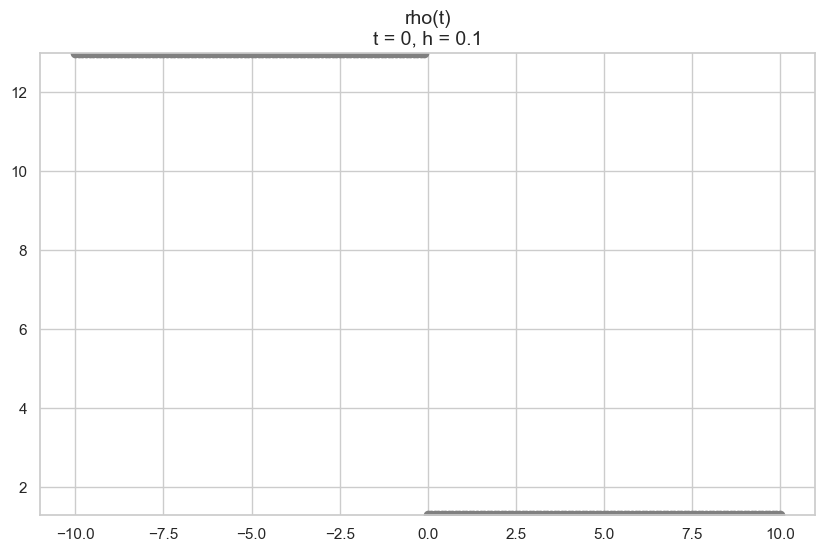

In [10]:
slv = Solver(0.1)
Solver.solveAndCreateGif()